### This notebook contains a few different versions of a reliability-esque imaging analysis where we tried to get a handle on how the violators differed from the rest of the subjects in terms of activation.


#### Version 1 does a split half procedure, but appeared to be pretty sensative to the random half selected

#### Version 2 moves to comparing against the full remainder sample

#### Version 3 includes a matched group along with the group of violators

In [1]:
import numpy as np
import random
import pandas as pd
import nibabel as nib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import seaborn as sns
import matplotlib.pyplot as plt

0 'correct_go',
1 'incorrect_go',
2 'correctlate_go',
3 'noresp_go',
4 'incorrectlate_go',
5 'correct_stop',
6 'incorrect_stop',
7 'ssd_stop',
8 'correct_go_vs_fixation',
9 'correct_stop_vs_correct_go',
10 'incorrect_stop_vs_correct_go',
11 'any_stop_vs_correct_go',
12 'correct_stop_vs_incorrect_stop',
13 'incorrect_go_vs_correct_go',
14 'incorrect_go_vs_incorrect_stop'

In [2]:
def get_cohens(data):

    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    cohen = mean / std

    return cohen

def get_corr_size_n(resid_data, base_cohens, n):

    np.random.seed(random.randint(1, 10000000))

    index = np.arange(0, len(resid_data))
    choices = np.random.choice(index, n, replace=False)
    cohens = get_cohens(resid_data[choices])

    return np.corrcoef(cohens, base_cohens)[0][1]

def load_data(data_loc):
    
    data = nib.load(data_loc).get_fdata()
    data = np.squeeze(data)
    data = np.transpose(data, (1,0))
    
    return data

def get_resid(to_resid, data):
    
    to_resid = np.array(to_resid)
    data = np.array(data)
    
    model = LinearRegression().fit(to_resid, data)
    dif = data - model.predict(to_resid)
    resid_data = model.intercept_ + dif
    
    return resid_data

def load_and_resid(contrast, subjects, img_subjs, covars):
    
    all_data = []
    
    options = ['cortical_lh_', 'cortical_rh_', 'subcortical_']
    for option in options:
        loc = 'alt_img_data/' + option + contrast + '.mgz'
        all_data.append(load_data(loc))
        print(all_data[-1].shape)
    data = np.concatenate(all_data, axis=1)

    subj_inds = [img_subjs.index(s) for s in subjects]
    return get_resid(covars.loc[subjects], data[subj_inds])

In [3]:
with open('clean_subj_subset.txt', 'r') as f:
    lines = f.readlines()
    subjs = [l.strip() for l in lines]
    
with open('clean_subj_vio.txt', 'r') as f:
    lines = f.readlines()
    vio_subjs = [l.strip() for l in lines]
    
with open('alt_img_data/final_subjects.txt', 'r') as f:
    lines = f.readlines()
    img_subjs = [l.strip() for l in lines]

In [4]:
subjects = list(set(img_subjs).intersection(set(subjs)))
len(subjects)

5258

In [5]:
vio = list(set(img_subjs).intersection(set(vio_subjs)))
len(vio)

257

In [6]:
non_vio_subjects = list(set(subjects) - set(vio))
len(non_vio_subjects)

5001

In [7]:
len(non_vio_subjects) - (257 * 2)

4487

In [8]:
#with open('non_vio_img_subset.txt', 'w') as f:
#    for s in non_vio_subjects:
#        f.write(s + '\n')
        
#with open('vio_img_subset.txt', 'w') as f:
#    for s in vio:
#        f.write(s + '\n')

In [9]:
covars = pd.read_csv('alt_img_data/covars_SST.csv', index_col='src_subject_id')
covars = covars.loc[subjects]
covars = covars.drop('tfmri_sst_all_beh_total_meanrt', axis=1)

# De-mean every column
for c in covars:
    covars[c] -= covars[c].mean()

In [10]:
def get_corrs(contrast, n):
   
    base_resid = load_and_resid(contrast, split1_subjs, img_subjs, covars)
    base_cohens = get_cohens(base_resid)

    compare_resid = load_and_resid(contrast, all_split2_subjs, img_subjs, covars)
    non_vio_resid = compare_resid[:len(split2_subjs)]
    
    corrs = []
    for i in range(n):
        corrs.append(get_corr_size_n(non_vio_resid, base_cohens, len(vio)))

    vio_resid = compare_resid[len(split2_subjs):]
    vio_corr = get_corr_size_n(vio_resid, base_cohens, len(vio))
    
    return corrs, vio_corr

def get_contrast(num, name, n):
    
    corrs, vio_corr = get_corrs(num, n)
    
    df = pd.DataFrame()
    df['cohens correlation with left-out group'] = corrs
    df['contrast'] = [name for i in range(len(corrs))]
    
    return df, vio_corr
    
def add_contrast(all_df, vio_corrs, num, name, n):
    
    df, vio_corr = get_contrast(num, name, n)
    
    mean = np.mean(df['cohens correlation with left-out group'])
    std = np.std(df['cohens correlation with left-out group'])
    print('vio std away from mean = ', ((mean-vio_corr) / std))
    
    all_df = all_df.append(df)
    vio_corrs.append(vio_corr)
    
    return all_df, vio_corrs

## Version 1

In [11]:
sp2_sz = int(((len(subjects) / 2) - len(vio)))

split1_subjs, split2_subjs = train_test_split(non_vio_subjects, test_size=sp2_sz, random_state=2)
all_split2_subjs = split2_subjs + vio

len(split1_subjs), len(all_split2_subjs)

(2629, 2629)

In [12]:
all_df = pd.DataFrame()
vio_corrs = []

n = 1000

all_df, vio_corrs = add_contrast(all_df, vio_corrs, '5', 'correct_stop', n)
all_df, vio_corrs = add_contrast(all_df, vio_corrs, '6', 'incorrect_stop', n)
all_df, vio_corrs = add_contrast(all_df, vio_corrs, '9', 'correct_stop_vs_correct_go', n)
all_df, vio_corrs = add_contrast(all_df, vio_corrs, '10', 'incorrect_stop_vs_correct_go', n)

(6204, 10242)
(6204, 10242)
(6204, 31870)
(6204, 10242)
(6204, 10242)
(6204, 31870)
vio std away from mean =  1.2638357779376588
(6204, 10242)
(6204, 10242)
(6204, 31870)
(6204, 10242)
(6204, 10242)
(6204, 31870)
vio std away from mean =  2.25346695553016
(6204, 10242)
(6204, 10242)
(6204, 31870)
(6204, 10242)
(6204, 10242)
(6204, 31870)
vio std away from mean =  2.3404088173634268
(6204, 10242)
(6204, 10242)
(6204, 31870)
(6204, 10242)
(6204, 10242)
(6204, 31870)
vio std away from mean =  6.315526491582606


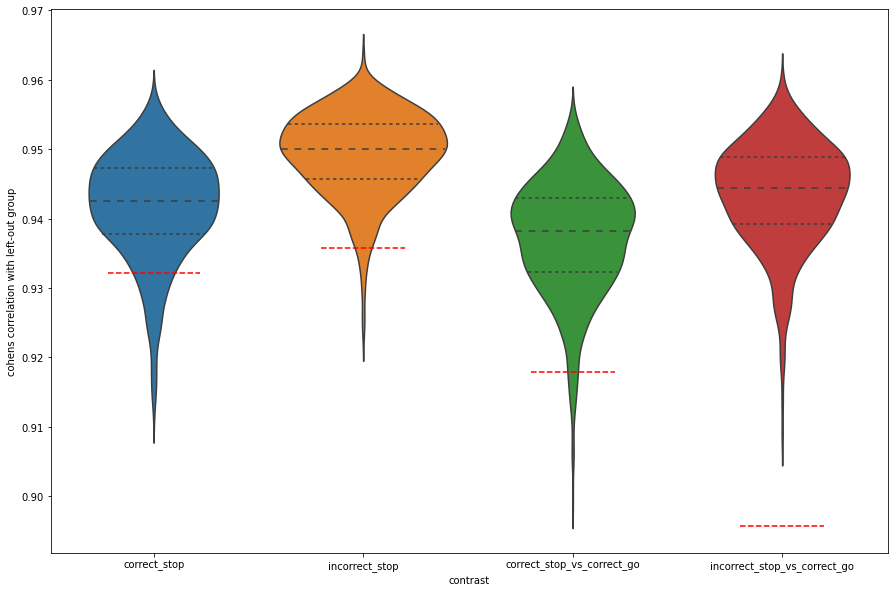

In [13]:
plt.figure(figsize=(15, 10))
sns.violinplot(x='contrast', y='cohens correlation with left-out group', data=all_df, inner='quartile')

plt.hlines(vio_corrs[0], -.22, .22, color='red', linestyles='dashed')
plt.hlines(vio_corrs[1], .8, 1.2, color='red', linestyles='dashed')
plt.hlines(vio_corrs[2], 1.8, 2.2,  color='red', linestyles='dashed')
plt.hlines(vio_corrs[3], 2.8, 3.2,  color='red', linestyles='dashed')
plt.savefig('plots/RelyLikeTest1.png', dpi=500)

Notice that with just one split results are a bit too variable depending on the split


## Version 2

In [14]:
def get_grp_corrs(non_vio_data, vio_data):
    
    choices = np.random.choice(np.arange(len(non_vio_data)), len(vio), replace=False)
    rest = [i for i in range(len(non_vio_data)) if i not in choices]
    
    standard_cohens = get_cohens(non_vio_data[rest])
    random_group_cohens = get_cohens(non_vio_data[choices])
    vio_cohens = get_cohens(vio_data)

    rand_corr = np.corrcoef(standard_cohens, random_group_cohens)[0][1]
    vio_corr = np.corrcoef(standard_cohens, vio_cohens)[0][1]

    return rand_corr, vio_corr 

def get_n_group_corr_dfs(contrast, name, n):
    
    all_data = load_and_resid(contrast, non_vio_subjects+vio, img_subjs, covars)
    non_vio_data = all_data[:len(non_vio_subjects)]
    vio_data = all_data[len(non_vio_subjects):]
    
    r_corrs, v_corrs = [], []
    
    for i in range(n):
        rc, vc =  get_grp_corrs(non_vio_data, vio_data)
        r_corrs.append(rc)
        v_corrs.append(vc)

    print('mean-vio std away from random-mean = ',
          ((np.mean(r_corrs)-np.mean(v_corrs)) / np.std(r_corrs)))
        
    r_df = pd.DataFrame()
    r_df['cohens correlation with left-out group'] = r_corrs
    r_df['contrast'] = [name for i in range(len(r_corrs))]
    
    v_df = pd.DataFrame()
    v_df['cohens correlation with left-out group'] = v_corrs
    v_df['contrast'] = [name for i in range(len(v_corrs))]
        
    return r_df, v_df

def add_grp_contrast(r_dfs, v_dfs, contrast, name, n):
    
    r_df, v_df = get_n_group_corr_dfs(contrast, name, n)
    
    r_dfs = r_dfs.append(r_df)
    v_dfs = v_dfs.append(v_df)
    
    return r_dfs, v_dfs


In [15]:
r_dfs, v_dfs = pd.DataFrame(), pd.DataFrame()

n = 1000

r_dfs, v_dfs = add_grp_contrast(r_dfs, v_dfs, '5', 'correct_stop', n)
r_dfs, v_dfs = add_grp_contrast(r_dfs, v_dfs, '9', 'correct_stop_vs_correct_go', n)

(6204, 10242)
(6204, 10242)
(6204, 31870)
mean-vio std away from random-mean =  1.3830195754060173
(6204, 10242)
(6204, 10242)
(6204, 31870)
mean-vio std away from random-mean =  2.952632250053587


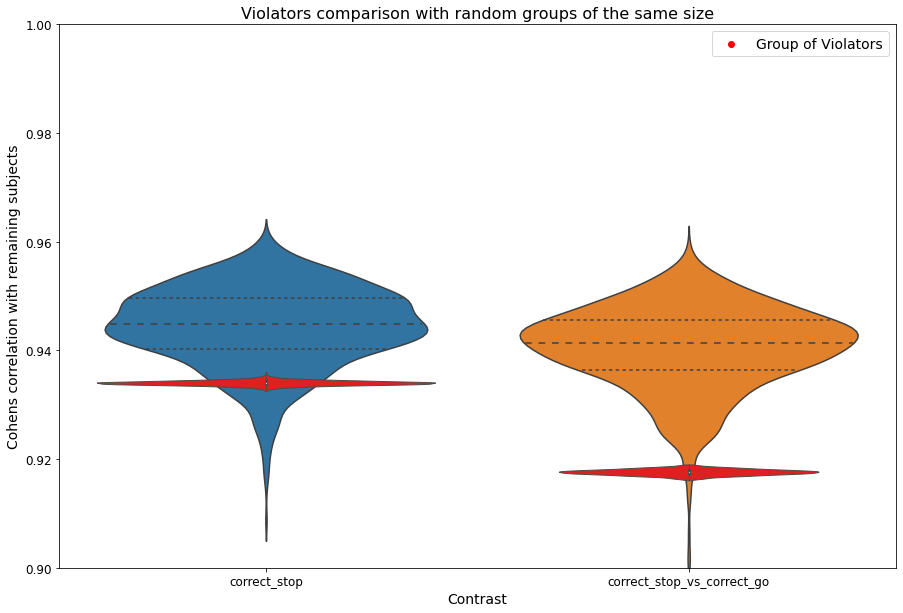

In [16]:
plt.figure(figsize=(15, 10))
sns.violinplot(x='contrast', y='cohens correlation with left-out group', data=r_dfs,
               inner='quartile', saturation=.75)
sns.violinplot(x='contrast', y='cohens correlation with left-out group', data=v_dfs, 
               inner='box', linewidth=1, color='red', saturation=.75, cut=False)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Contrast', fontsize=14)
plt.ylabel('Cohens correlation with remaining subjects', fontsize=14)
plt.title('Violators comparison with random groups of the same size', fontsize=16)
plt.ylim(.9, 1)

plt.scatter(0,0, color='red', label='Group of Violators')
plt.legend(fontsize=14)


plt.savefig('plots/RelyLikeTest2.png', dpi=400)

### Version 3

In [17]:
with open('/home/sage/Downloads/matchedNV.csv', 'r') as f:
    lines = f.readlines()
    match1 = [l.strip() for l in lines]
    match1.remove('src_subject_id')
    
with open('/home/sage/Downloads/matchedNV_withSFRT.csv', 'r') as f:
    lines = f.readlines()
    match2 = [l.strip() for l in lines]
    match2.remove('src_subject_id')

In [18]:
def get_grp_corrs_match(non_vio_data, vio_data, match_data):
    
    choices = np.random.choice(np.arange(len(non_vio_data)), len(vio), replace=False)
    rest = [i for i in range(len(non_vio_data)) if i not in choices]
    
    standard_cohens = get_cohens(non_vio_data[rest])
    random_group_cohens = get_cohens(non_vio_data[choices])
    vio_cohens = get_cohens(vio_data)
    match_cohens = get_cohens(match_data)

    rand_corr = np.corrcoef(standard_cohens, random_group_cohens)[0][1]
    vio_corr = np.corrcoef(standard_cohens, vio_cohens)[0][1]
    match_corr = np.corrcoef(standard_cohens, match_cohens)[0][1]

    return rand_corr, vio_corr, match_corr

def get_n_group_corr_dfs_match(contrast, name, n, match):
    
    all_data = load_and_resid(contrast, non_vio_subjects+vio+match, img_subjs, covars)
    
    non_vio_data = all_data[:len(non_vio_subjects)]
    vio_data = all_data[len(non_vio_subjects):len(non_vio_subjects)+len(vio)]
    match_data = all_data[len(non_vio_subjects)+len(vio):]
    
    r_corrs, v_corrs, m_corrs = [], [], []
    
    for i in range(n):
        rc, vc, mc =  get_grp_corrs_match(non_vio_data, vio_data, match_data)
        r_corrs.append(rc)
        v_corrs.append(vc)
        m_corrs.append(mc)

    print('mean-vio std away from random-mean = ',
          ((np.mean(r_corrs)-np.mean(v_corrs)) / np.std(r_corrs)))
    print('mean-match std away from random-mean = ',
          ((np.mean(r_corrs)-np.mean(m_corrs)) / np.std(r_corrs)))
        
    r_df = pd.DataFrame()
    r_df['cohens correlation with left-out group'] = r_corrs
    r_df['contrast'] = [name for i in range(len(r_corrs))]
    
    v_df = pd.DataFrame()
    v_df['cohens correlation with left-out group'] = v_corrs
    v_df['contrast'] = [name for i in range(len(v_corrs))]
    
    m_df = pd.DataFrame()
    m_df['cohens correlation with left-out group'] = m_corrs
    m_df['contrast'] = [name for i in range(len(m_corrs))]
        
    return r_df, v_df, m_df

def add_grp_contrast_match(r_dfs, v_dfs, m_dfs, contrast, name, n, match):
    
    r_df, v_df, m_df = get_n_group_corr_dfs_match(contrast, name, n, match)
    
    r_dfs = r_dfs.append(r_df)
    v_dfs = v_dfs.append(v_df)
    m_dfs = m_dfs.append(m_df)
    
    return r_dfs, v_dfs, m_dfs

In [ ]:
r_dfs, v_dfs, m_dfs = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

n = 10000

r_dfs, v_dfs, m_dfs = add_grp_contrast_match(r_dfs, v_dfs, m_dfs, '5', 'correct_stop', n, match1)
r_dfs, v_dfs, m_dfs = add_grp_contrast_match(r_dfs, v_dfs, m_dfs, '9', 'correct_stop_vs_correct_go', n, match1)

(6204, 10242)
(6204, 10242)
(6204, 31870)


In [ ]:
plt.figure(figsize=(15, 10))
sns.violinplot(x='contrast', y='cohens correlation with left-out group', data=r_dfs,
               inner='quartile', saturation=.75)
sns.violinplot(x='contrast', y='cohens correlation with left-out group', data=v_dfs, 
               inner='box', linewidth=1, color='red', saturation=.75, cut=False)
sns.violinplot(x='contrast', y='cohens correlation with left-out group', data=m_dfs, 
               inner='box', linewidth=1, color='green', saturation=.75, cut=False)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Contrast', fontsize=14)
plt.ylabel('Cohens correlation with remaining subjects', fontsize=14)
plt.title('Violators comparison with random groups of the same size', fontsize=16)
plt.ylim(.9, 1)

plt.scatter(0,0, color='red', label='Group of Violators')
plt.scatter(0,0, color='green', label='Matched Group')
plt.legend(fontsize=14)

plt.savefig('plots/RelyLikeTest3_m1_10k.png', dpi=400)

In [ ]:
vc1 = np.mean(v_dfs[v_dfs['contrast'] == 'correct_stop']['cohens correlation with left-out group'])
mc1 = np.mean(m_dfs[m_dfs['contrast'] == 'correct_stop']['cohens correlation with left-out group'])
rc1 = np.mean(r_dfs[r_dfs['contrast'] == 'correct_stop']['cohens correlation with left-out group'])

print(vc1, mc1, rc1)

vc2 = np.mean(v_dfs[v_dfs['contrast'] == 'correct_stop_vs_correct_go']['cohens correlation with left-out group'])
mc2 = np.mean(m_dfs[m_dfs['contrast'] == 'correct_stop_vs_correct_go']['cohens correlation with left-out group'])
rc2 = np.mean(r_dfs[r_dfs['contrast'] == 'correct_stop_vs_correct_go']['cohens correlation with left-out group'])

print(vc2, mc2, rc2)

plt.figure(figsize=(15, 10))
sns.violinplot(x='contrast', y='cohens correlation with left-out group', data=r_dfs,
               inner='quartile', saturation=.75)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Contrast', fontsize=16)
plt.ylabel('Cohens correlation with remaining subjects', fontsize=18)
plt.title('Violators comparison with random groups of the same size', fontsize=18)
plt.ylim(.9, 1)

plt.hlines(vc1, -.25, .25, color='red', linestyles='dashed', linewidth=3, label='Group of Violators')
plt.hlines(mc1, -.25, .25, color='green', linestyles='dashed', linewidth=3, label='Matched Group')

plt.hlines(vc2, .75, 1.25, color='red', linestyles='dashed', linewidth=3)
plt.hlines(mc2, .75, 1.25, color='green', linestyles='dashed', linewidth=3)

plt.legend(fontsize=16)
plt.savefig('plots/RelyLikeTest3_m1_alt_10k.png', dpi=400)

In [ ]:
r_dfs, v_dfs, m_dfs = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

n = 1000

r_dfs, v_dfs, m_dfs = add_grp_contrast_match(r_dfs, v_dfs, m_dfs, '5', 'correct_stop', n, match2)
r_dfs, v_dfs, m_dfs = add_grp_contrast_match(r_dfs, v_dfs, m_dfs, '9', 'correct_stop_vs_correct_go', n, match2)

In [ ]:
plt.figure(figsize=(15, 10))
sns.violinplot(x='contrast', y='cohens correlation with left-out group', data=r_dfs,
               inner='quartile', saturation=.75)
sns.violinplot(x='contrast', y='cohens correlation with left-out group', data=v_dfs, 
               inner='box', linewidth=1, color='red', saturation=.75, cut=False)
sns.violinplot(x='contrast', y='cohens correlation with left-out group', data=m_dfs, 
               inner='box', linewidth=1, color='green', saturation=.75, cut=False)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Contrast', fontsize=14)
plt.ylabel('Cohens correlation with remaining subjects', fontsize=14)
plt.title('Violators comparison with random groups of the same size', fontsize=16)
plt.ylim(.9, 1)

plt.scatter(0,0, color='red', label='Group of Violators')
plt.scatter(0,0, color='green', label='Matched Group')
plt.legend(fontsize=14)

plt.savefig('plots/RelyLikeTest3_m2.png', dpi=400)

In [ ]:
vc1 = np.mean(v_dfs[v_dfs['contrast'] == 'correct_stop']['cohens correlation with left-out group'])
mc1 = np.mean(m_dfs[m_dfs['contrast'] == 'correct_stop']['cohens correlation with left-out group'])

vc2 = np.mean(v_dfs[v_dfs['contrast'] == 'correct_stop_vs_correct_go']['cohens correlation with left-out group'])
mc2 = np.mean(m_dfs[m_dfs['contrast'] == 'correct_stop_vs_correct_go']['cohens correlation with left-out group'])

plt.figure(figsize=(15, 10))
sns.violinplot(x='contrast', y='cohens correlation with left-out group', data=r_dfs,
               inner='quartile', saturation=.75)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Contrast', fontsize=14)
plt.ylabel('Cohens correlation with remaining subjects', fontsize=14)
plt.title('Violators comparison with random groups of the same size', fontsize=16)
plt.ylim(.9, 1)

plt.hlines(vc1, -.25, .25, color='red', linestyles='dashed', linewidth=3, label='Group of Violators')
plt.hlines(mc1, -.25, .25, color='green', linestyles='dashed', linewidth=3, label='Matched Group')

plt.hlines(vc2, .75, 1.25, color='red', linestyles='dashed', linewidth=3)
plt.hlines(mc2, .75, 1.25, color='green', linestyles='dashed', linewidth=3)

plt.legend(fontsize=14)
plt.savefig('plots/RelyLikeTest3_m2_alt.png', dpi=400)